In [ ]:
# !pip install tensorflow==2.8.0

In [ ]:
# !wget https://raw.githubusercontent.com/Topaz52/phishing-website-URL-dataset/main/phishtank_phishing_raw.csv
# !wget https://raw.githubusercontent.com/Topaz52/phishing-website-URL-dataset/main/zenodo_benign_raw.csv

--2023-12-28 05:32:27--  https://raw.githubusercontent.com/Topaz52/phishing-website-URL-dataset/main/phishtank_phishing_raw.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12311377 (12M) [text/plain]
Saving to: ‘phishtank_phishing_raw.csv’

phishtank_phishing_ 100%[===================>]  11.74M  --.-KB/s    in 0.1s    

2023-12-28 05:32:28 (118 MB/s) - ‘phishtank_phishing_raw.csv’ saved [12311377/12311377]

--2023-12-28 05:32:28--  https://raw.githubusercontent.com/Topaz52/phishing-website-URL-dataset/main/zenodo_benign_raw.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP 

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from prettytable import PrettyTable
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.8.0


In [ ]:
# Some high level parameters:
show_top_n = 20
random_seed = 16

# Setting the random seed so that the code is repeatable.
np.random.seed(random_seed)

In [ ]:
# Loading the current combined online-valid dataset.
# Use the dataset_downloader.py to download the current Phishtank online-valid.csv and update the combined dataset.
print("Phishtank Online Valid Dataset")
online_valid_df = pd.read_csv("phishtank_phishing_raw.csv")
online_valid_df

Phishtank Online Valid Dataset


,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target
0,8139518,https://bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixg...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:53+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other
1,8139517,https://cf-ipfs.com/ipfs/QmV1W4NpL5LNvgyNVsV8W...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:52+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other
2,8139516,https://bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixg...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:50+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other
3,8139514,https://ipfs.eth.aragon.network/ipfs/bafybeidd...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:49+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other
4,8139515,https://ipfs.eth.aragon.network/ipfs/bafybeidd...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:49+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other
...,...,...,...,...,...,...,...,...
64338,1865971,http://www.formbuddy.com/cgi-bin/formdisp.pl?u...,http://www.phishtank.com/phish_detail.php?phis...,2013-05-28T15:59:31+00:00,yes,2013-05-28T22:13:12+00:00,yes,Other
64339,1850379,https://sites.google.com/site/libretyreserve/,http://www.phishtank.com/phish_detail.php?phis...,2013-05-18T23:52:56+00:00,yes,2013-05-19T13:45:13+00:00,yes,Other
64340,1460953,http://www.habbocreditosparati.blogspot.com/,http://www.phishtank.com/phish_detail.php?phis...,2012-06-14T15:19:26+00:00,yes,2012-06-14T15:29:11+00:00,yes,Sulake Corporation
64341,1123978,http://creditiperhabbogratissicuro100.blogspot...,http://www.phishtank.com/phish_detail.php?phis...,2011-02-18T10:50:32+00:00,yes,2011-02-19T00:05:43+00:00,yes,Sulake Corporation


In [ ]:
# Extracting tld and domain name.
tld_count = defaultdict(lambda: 0)
domain_names = []
for index, row in online_valid_df.iterrows():
    # Extracting the tld from the url
    domain_name = row["url"].replace("https://","").replace("http://","").replace("www.","").split("/")[0]
    domain_names.append(domain_name)
    tld = domain_name.split(".")[-1]
    tld_count[tld] += 1

tld_df = pd.Series(dict(tld_count))
tld_df.sort_values(ascending=False, inplace=True)
tld_print = tld_df.iloc[:show_top_n]
tld_print["OTHERS"] = tld_df.iloc[show_top_n:].sum()

In [ ]:
# Adding the domain names extracted from the phishing urls as a new column.
online_valid_df["domain_names"] = domain_names

**Load benign dataset**

In [ ]:
# Loading the whitelist from the 1 million most frequently visited domains.
# whitelist_file_umbrella = "benign_websites.csv"
whitelist_df = pd.read_csv("zenodo_benign_raw.csv")
whitelist_df

,URLs,Label
0,http://www.wmmayhem.com/,Benign
1,http://www.ballymenaunitedyouthacademy.com/,Benign
2,http://www.brusselsgaybars.com/,Benign
3,http://www.sportsbettingtennis.net/,Benign
4,http://www.i29.mobi/,Benign
...,...,...
19395,http://www.twitt.org/,Benign
19396,http://www.people.famouswhy.com/lucy_rangel/,Benign
19397,http://www.badoo.com/0139730059/,Benign
19398,http://www.mccrearyrecord.com/obituaries/x2018...,Benign


In [ ]:
# Extracting tld and domain name.
tld_count = defaultdict(lambda: 0)
domain_names = []
for index, row in whitelist_df.iterrows():
    # Extracting the tld from the url
    domain_name = row["URLs"].replace("https://","").replace("http://","").replace("www.","").split("/")[0]
    domain_names.append(domain_name)
    tld = domain_name.split(".")[-1]
    tld_count[tld] += 1

tld_df = pd.Series(dict(tld_count))
tld_df.sort_values(ascending=False, inplace=True)
tld_print = tld_df.iloc[:show_top_n]
tld_print["OTHERS"] = tld_df.iloc[show_top_n:].sum()

In [ ]:
# Adding the domain names extracted from the phishing urls as a new column.
whitelist_df["domain_names"] = domain_names

In [ ]:
whitelist_df

,URLs,Label,domain_names
0,http://www.wmmayhem.com/,Benign,wmmayhem.com
1,http://www.ballymenaunitedyouthacademy.com/,Benign,ballymenaunitedyouthacademy.com
2,http://www.brusselsgaybars.com/,Benign,brusselsgaybars.com
3,http://www.sportsbettingtennis.net/,Benign,sportsbettingtennis.net
4,http://www.i29.mobi/,Benign,i29.mobi
...,...,...,...
19395,http://www.twitt.org/,Benign,twitt.org
19396,http://www.people.famouswhy.com/lucy_rangel/,Benign,people.famouswhy.com
19397,http://www.badoo.com/0139730059/,Benign,badoo.com
19398,http://www.mccrearyrecord.com/obituaries/x2018...,Benign,mccrearyrecord.com


In [ ]:
# Finding if there are any domains that are also in the whitelist.
domains_in_whitelist = np.intersect1d(online_valid_df["domain_names"], whitelist_df["domain_names"])
# Tagging the whitelisted domains as such.
online_valid_df["in_whitelist"] = np.in1d(online_valid_df["domain_names"], domains_in_whitelist)

In [ ]:
# Printing some data examples for reference.
print(online_valid_df.shape[0], "rows")
print(tld_print.to_frame(name="TLD Count").transpose().to_string())
print(f"Percentage of top {show_top_n} tlds: {np.round(100*tld_df.iloc[:show_top_n].sum()/tld_df.sum(), decimals=2)} %")
online_valid_df.head(20)

64343 rows
             com   org  net  edu   ca  gov  uk  info  au  us  eu  biz  tv  at  de  me  se  nl  ws  in  OTHERS
TLD Count  14524  2909  563  476  351  130  55    52  43  30  20   13  11  11  10   9   9   9   9   8     158
Percentage of top 20 tlds: 99.19 %


,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target,domain_names,in_whitelist
0,8139518,https://bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixg...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:53+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other,bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixgbmdvjfnq...,False
1,8139517,https://cf-ipfs.com/ipfs/QmV1W4NpL5LNvgyNVsV8W...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:52+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other,cf-ipfs.com,False
2,8139516,https://bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixg...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:50+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other,bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixgbmdvjfnq...,False
3,8139514,https://ipfs.eth.aragon.network/ipfs/bafybeidd...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:49+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other,ipfs.eth.aragon.network,False
4,8139515,https://ipfs.eth.aragon.network/ipfs/bafybeidd...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:49+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other,ipfs.eth.aragon.network,False
5,8139513,https://cloudflare-ipfs.com/ipfs/bafybeidddh67...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:46+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other,cloudflare-ipfs.com,False
6,8139512,https://gateway.pinata.cloud/ipfs/bafybeidddh6...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:45+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other,gateway.pinata.cloud,False
7,8139510,https://bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixg...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:43+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other,bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixgbmdvjfnq...,False
8,8139511,https://bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixg...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:43+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other,bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixgbmdvjfnq...,False
9,8139509,https://bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixg...,http://www.phishtank.com/phish_detail.php?phis...,2023-05-06T03:56:41+00:00,yes,2023-05-06T04:03:21+00:00,yes,Other,bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixgbmdvjfnq...,False


In [ ]:
# Printing the top of the whitelist.
print("Whitelist file:", whitelist_df)
# print(whitelist_df.shape[0], "rows")
print(whitelist_df.tail(20))

Whitelist file:                                                     URLs   Label  \
0                               http://www.wmmayhem.com/  Benign   
1            http://www.ballymenaunitedyouthacademy.com/  Benign   
2                        http://www.brusselsgaybars.com/  Benign   
3                    http://www.sportsbettingtennis.net/  Benign   
4                                   http://www.i29.mobi/  Benign   
...                                                  ...     ...   
19395                              http://www.twitt.org/  Benign   
19396       http://www.people.famouswhy.com/lucy_rangel/  Benign   
19397                   http://www.badoo.com/0139730059/  Benign   
19398  http://www.mccrearyrecord.com/obituaries/x2018...  Benign   
19399                    http://www.daviswiki.org/Amtrak  Benign   

                          domain_names  
0                         wmmayhem.com  
1      ballymenaunitedyouthacademy.com  
2                  brusselsgaybars.com  
3  

In [ ]:
# How many domains are in both the whitelist and in the phishing urls?
print()
print("Number of urls that have domains which are in the whilelist:", online_valid_df["in_whitelist"].sum())

# # Print the URLs that are in the whitelist
# whitelisted_urls = online_valid_df.loc[online_valid_df["in_whitelist"], "url"]
# print("Whitelisted URLs:")
# for url in whitelisted_urls:
#     print(url)


Number of urls that have domains which are in the whilelist: 303


In [ ]:
# For the dataset, excluding all where the domain name is in the whitelist.
# Since if the domain is in both lists we cannot tell if its safe or phishing? --> This helps with labeleling the data.
online_valid_df_without_intersection = online_valid_df.loc[online_valid_df['in_whitelist'] == False]
whitelist_df_without_intersection = whitelist_df.loc[np.invert(whitelist_df['domain_names'].isin(domains_in_whitelist))]

In [ ]:
# Set oversampling_rate to 1 to have the positive samples match the phishing samples. Set to greater than 1 to use more negative samples.
oversampling_rate = 1.5

# Getting the array of all phishing domain names.
phishing_domains = online_valid_df_without_intersection["domain_names"].values
# Randomly sample a number of safe urls, sice the ratio of classes in the training data should not be too much out of balance.
whitelist_domains = np.random.choice(whitelist_df_without_intersection["domain_names"].values, size=int(oversampling_rate*len(phishing_domains)), replace=True)

In [ ]:
print("Selected Data Examples:")
print("Phishing domains:", phishing_domains, len(phishing_domains))
print("Benign domains:", whitelist_domains, len(whitelist_domains))

Selected Data Examples:
Phishing domains: ['bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixgbmdvjfnqdoxi2w4k4h3am.ipfs.cf-ipfs.com'
 'cf-ipfs.com'
 'bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixgbmdvjfnqdoxi2w4k4h3am.ipfs.dweb.link'
 ... 'habbocreditosparati.blogspot.com'
 'creditiperhabbogratissicuro100.blogspot.com' 'aijcs.blogspot.com'] 64040
Benign domains: ['vimeo.com' 'local.yahoo.com' 'restaurantlebeffroi.foodpages.ca' ...
 'people.famouswhy.com' 'encyclopedia2.thefreedictionary.com'
 'connect.in.com'] 96060


In [ ]:
# Calling a phishing url 1 and a not-phishing url 0.
# Using character encoding as the vocabulary.
# Feeding the url as the sequence.
# Creating the samples array and the label array
print()
X = list(phishing_domains) + list(whitelist_domains)
y = [1]*len(phishing_domains) + [0]*len(whitelist_domains)
sample_weights = [1]*len(phishing_domains) + [1/oversampling_rate]*len(whitelist_domains)

In [ ]:
# Encoding code/idea from TensorFlow 2.0 Complete Course - Python Neural Networks for Beginners Tutorial freeCodeCamp.org
# https://colab.research.google.com/drive/1ysEKrw_LE2jMndo1snrZUh5w87LQsCxk#forceEdit=true&sandboxMode=true
vocab = sorted(set("".join(X)), reverse=True)
# Inserting a space at index 0, since it is not used in url and will be used for padding the examples.
vocab.insert(0, " ")
vocab_size = len(vocab)

print()
print(f"Encoding Vocabulary ({vocab_size}) used:")
print(vocab)
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

def text_to_int(text):
  return np.array([char2idx[c] for c in text])

print("Encoding example:")
print(text_to_int(phishing_domains[0]))

def int_to_text(ints):
  try:
    ints = ints.numpy()
  except:
    pass
  return ''.join(idx2char[ints])

print(int_to_text(text_to_int(phishing_domains[0])))


Encoding Vocabulary (84) used:
[' ', 'я', 'ъ', 'ф', 'у', 'с', 'р', 'н', 'м', 'и', 'е', 'д', 'б', 'а', 'z', 'y', 'x', 'w', 'v', 'u', 't', 's', 'r', 'q', 'p', 'o', 'n', 'm', 'l', 'k', 'j', 'i', 'h', 'g', 'f', 'e', 'd', 'c', 'b', 'a', '_', 'Z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A', '@', '?', '=', ':', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0', '.', '-', '#']
Encoding example:
[38 39 34 15 38 35 31 36 36 36 32 74 73 39 24 77 25 30 75 31 18 16 27 25
 33 28 39 26 17 30 27 29 22 27 75 31 16 33 38 27 36 18 30 34 26 23 36 25
 16 31 78 17 76 29 76 32 77 39 27 81 31 24 34 21 81 37 34 82 31 24 34 21
 81 37 25 27]
bafybeidddh67ap3oj5ivxmoglanwjmkrm5ixgbmdvjfnqdoxi2w4k4h3am.ipfs.cf-ipfs.com


In [ ]:
# Investigating the domain name length for the combined domain names:
X_elem_len = [len(domain_name) for domain_name in X]
print(sorted(X_elem_len, reverse=True)[:show_top_n])

[194, 110, 102, 101, 101, 101, 101, 99, 98, 97, 97, 94, 94, 93, 93, 91, 91, 91, 91, 91]


In [ ]:
# Setting some max length for our urls.
max_seq_len = 40
print((np.array(X_elem_len) > max_seq_len).sum(), "URLs longer than the cutoff length", max_seq_len)

9409 URLs longer than the cutoff length 40


In [ ]:
X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(np.array(X),
                                                                                               np.array(y),
                                                                                               np.array(sample_weights),
                                                                                               test_size=0.15,
                                                                                               random_state=random_seed)

In [ ]:
# Reducing how many samples to print so printouts dont get so big.
show_top_n = 5
print(f"Training and testing data: (showing first {show_top_n})")
print(f"Train data {len(X_train)} samples")
print(list(zip(X_train[:show_top_n], y_train[:show_top_n], sample_weights_train[:show_top_n])))
print(f"Test data {len(X_test)} samples")
print(list(zip(X_test[:show_top_n], y_test[:show_top_n], sample_weights_test[:show_top_n])))

Training and testing data: (showing first 5)
Train data 136085 samples
[('encyclopedia2.thefreedictionary.com', 0, 0.6666666666666666), ('rebrand.ly', 1, 1.0), ('pipl.com', 0, 0.6666666666666666), ('njvgiqmsiz.duckdns.org', 1, 1.0), ('buildingstapleton.blogspot.com', 0, 0.6666666666666666)]
Test data 24015 samples
[('m.rollingstone.com', 0, 0.6666666666666666), ('itunes.apple.com', 0, 0.6666666666666666), ('spyglobalcuisine.com', 0, 0.6666666666666666), ('compare.productwiki.com', 0, 0.6666666666666666), ('mersinesc.net', 1, 1.0)]


In [ ]:
# Encoding the domain names using the vocabulary
X_train_encoded = [text_to_int(domain_name) for domain_name in X_train]
X_test_encoded = [text_to_int(domain_name) for domain_name in X_test]
print()
print(f"Encoded data: (showing first {show_top_n})")
print(f"Train data {len(X_train_encoded)} samples, encoded")
print(list(zip(X_train_encoded[:show_top_n], y_train[:show_top_n])))
print(f"Test data {len(X_test_encoded)} samples, encoded")
print(list(zip(X_test_encoded[:show_top_n], y_test[:show_top_n])))

# Padding to the right sequence length.
X_train_encoded_padded = sequence.pad_sequences(X_train_encoded, max_seq_len)
X_test_encoded_padded = sequence.pad_sequences(X_test_encoded, max_seq_len)
print()
print(f"Encoded and padded data: (showing first {show_top_n})")
print(f"Train data {len(X_train_encoded_padded)} samples, encoded")
print(list(zip(X_train_encoded_padded[:show_top_n], y_train[:show_top_n])))
print(f"Test data {len(X_test_encoded_padded)} samples, encoded")
print(list(zip(X_test_encoded_padded[:show_top_n], y_test[:show_top_n])))


Encoded data: (showing first 5)
Train data 136085 samples, encoded
[(array([35, 26, 37, 15, 37, 28, 25, 24, 35, 36, 31, 39, 78, 81, 20, 32, 35,
       34, 22, 35, 35, 36, 31, 37, 20, 31, 25, 26, 39, 22, 15, 81, 37, 25,
       27]), 0), (array([22, 35, 38, 22, 39, 26, 36, 81, 28, 15]), 1), (array([24, 31, 24, 28, 81, 37, 25, 27]), 0), (array([26, 30, 18, 33, 31, 23, 27, 21, 31, 14, 81, 36, 19, 37, 29, 36, 26,
       21, 81, 25, 22, 33]), 1), (array([38, 19, 31, 28, 36, 31, 26, 33, 21, 20, 39, 24, 28, 35, 20, 25, 26,
       81, 38, 28, 25, 33, 21, 24, 25, 20, 81, 37, 25, 27]), 0)]
Test data 24015 samples, encoded
[(array([27, 81, 22, 25, 28, 28, 31, 26, 33, 21, 20, 25, 26, 35, 81, 37, 25,
       27]), 0), (array([31, 20, 19, 26, 35, 21, 81, 39, 24, 24, 28, 35, 81, 37, 25, 27]), 0), (array([21, 24, 15, 33, 28, 25, 38, 39, 28, 37, 19, 31, 21, 31, 26, 35, 81,
       37, 25, 27]), 0), (array([37, 25, 27, 24, 39, 22, 35, 81, 24, 22, 25, 36, 19, 37, 20, 17, 31,
       29, 31, 81, 37, 25, 27])

In [ ]:
def evaluate_nn_model(X, y, threshold=0.5, bins=5, graph_bins=15, examples_per_bin=15):
    """
    Custom nn evaluation to get the TP, TN, FP, FN rates.
    Anything below threshold is considered not phishing.
    Anything above threshold is considered phishing.
    """
    predictions = model.predict(X).flatten()
    mean_prediction = np.mean(predictions)
    print(f"Calculated {len(predictions)} predictions with a mean value of {mean_prediction}")
    print(f"Evaluating using threshold {threshold}")
    # Turning the predictions into 0 and 1 by checking the threshold. (0 safe, 1 phishing)
    predictions_boolean = predictions > threshold
    predictions_binary = predictions_boolean.astype(np.int)
    print(f"Cut-off threshold: {np.round(threshold, decimals=4)}")
    groundtruth_elements, groundtruth_counts = np.unique(y, return_counts=True)
    groundtruth_counts = dict(zip(groundtruth_elements, groundtruth_counts))
    evaluation_ratios_counts, sample_outcomes = statistics_evaluator(predictions_binary, y)
    statistics_table_printer(evaluation_ratios_counts)
    # showing some examples for each type of outcome: 0 TN, 1 FP, 2 FN, 3 TP
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    outcome_index = [0, 1, 2, 3]
    outcome_plot_positions = [0, 1, 2, 3]
    outcome_labels = ["TN", "FP", "FN", "TP"]
    y_axis_max = 0
    for outcome in outcome_index:
        outcome_indexes = np.where(np.array(sample_outcomes) == outcome)[0]
        # Instead of random samples, do a histogram with bins of the predictions for this outcome.
        # Then sample examples from each bin.
        outcome_predictions = predictions[outcome_indexes]
        outcome_binary = [ int(ind) for ind in list(str(bin(outcome_plot_positions[outcome])).replace("0b","").rjust(2, "0"))]
        outcome_hist, outcome_bins = np.histogram(outcome_predictions, bins=bins)
        plot_hist, plot_bins = np.histogram(outcome_predictions, bins=graph_bins)
        outcome_total_count = groundtruth_counts[outcome_binary[0]]
        plot_hist = (100*np.array(plot_hist))/outcome_total_count
        axs[outcome_binary[0], outcome_binary[1]].bar(plot_bins[:-1], plot_hist, width = plot_bins[1]-plot_bins[0], align="edge")
        y_axis_max = max( max(plot_hist), y_axis_max)
        axs[outcome_binary[0], outcome_binary[1]].set_title(outcome_labels[outcome])
        # Randomly sample some examples from each bin for this outcome:
        for bin_start, bin_end in zip(outcome_bins[:-1], outcome_bins[1:]):
            bin_outcome_indexes = np.where( np.logical_and( np.array(outcome_predictions) >= bin_start, np.array(outcome_predictions) < bin_end ))[0]
            bin_outcome_indexes = outcome_indexes[bin_outcome_indexes]
            if len(bin_outcome_indexes) > examples_per_bin:
                chosen_bin_outcome_examples = np.random.choice(bin_outcome_indexes, size=examples_per_bin, replace=False)
            else:
                chosen_bin_outcome_examples = bin_outcome_indexes
            example_truth = y[chosen_bin_outcome_examples]
            example_input_encoded = X[chosen_bin_outcome_examples]
            example_input_decoded = [ int_to_text(example).strip() for example in example_input_encoded]
            example_prediction = predictions[chosen_bin_outcome_examples]
            example_df = pd.DataFrame(data={"input": example_input_decoded, "ground truth": example_truth, "prediction": example_prediction})
            print("\nExamples for", outcome_labels[outcome], "Bin range:", bin_start, "-", bin_end, ", Num. Samples:", len(bin_outcome_indexes))
            print(example_df.to_string())
    for ax in axs.flat:
        ax.set(xlabel='Prediction', ylabel='Percentage of samples')
        ax.set_ylim(0, y_axis_max*1.02)
        ax.grid()
    plt.tight_layout()
    fig.savefig('outcome_distributions.pdf')
    return mean_prediction

def statistics_evaluator(predictions_binary, y_binary):
    # Concattenating the strings of the binary value of the prediction and the truth.
    # First value is the prediction, second the actual label
    # Hypothesis is: is phishing -> positive: yes phishing, negative: no phishing
    # Then 00 would be a TN, 01 is a FP, 10 is a FN, 11 is a TP.
    # Converting the binary outcomes to integer: 0 TN, 1 FP, 2 FN, 3 TP
    hypothesis_tests = [int(str(label)+str(prediction), 2) for prediction, label in zip(predictions_binary, y_binary)]
    # Counting the number of times each unique value in the tests is returned.
    unique_elements, counts_elements = np.unique(hypothesis_tests, return_counts=True)
    counts_elements = dict(zip(unique_elements, counts_elements))
    outcome_labels = ["TN", "FP", "FN", "TP"]
    evaluation_ratios_counts = dict(zip(outcome_labels, [counts_elements.get(0, 0), counts_elements.get(1, 0), counts_elements.get(2, 0), counts_elements.get(3, 0)]))
    return evaluation_ratios_counts, hypothesis_tests

def statistics_table_printer(evaluation_ratios_counts, decimals=3):
    print("Evaluation counts:", evaluation_ratios_counts)
    try:
        positive_predictive_value = evaluation_ratios_counts["TP"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FP"])
    except:
        positive_predictive_value = 0
    try:
        true_positive_rate = evaluation_ratios_counts["TP"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FN"])
    except:
        true_positive_rate = 0
    try:
        false_discovery_rate = evaluation_ratios_counts["FP"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FP"])
    except:
        false_discovery_rate = 0
    try:
        false_positive_rate = evaluation_ratios_counts["FP"]/(evaluation_ratios_counts["FP"]+evaluation_ratios_counts["TN"])
    except:
        false_positive_rate = 0
    try:
        false_omission_rate = evaluation_ratios_counts["FN"]/(evaluation_ratios_counts["TN"]+evaluation_ratios_counts["FN"])
    except:
        false_omission_rate = 0
    try:
        false_negative_rate = evaluation_ratios_counts["FN"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FN"])
    except:
        false_negative_rate = 0
    try:
        negative_predictive_value = evaluation_ratios_counts["TN"]/(evaluation_ratios_counts["TN"]+evaluation_ratios_counts["FN"])
    except:
        negative_predictive_value = 0
    try:
        true_negative_rate = evaluation_ratios_counts["TN"]/(evaluation_ratios_counts["TN"]+evaluation_ratios_counts["FP"])
    except:
        true_negative_rate = 0
    try:
        accuracy = (evaluation_ratios_counts.get("TP",0)+evaluation_ratios_counts.get("TN",0))/(evaluation_ratios_counts.get("TP",0)+evaluation_ratios_counts.get("TN",0) + evaluation_ratios_counts.get("FP",0) + evaluation_ratios_counts.get("FN",0))
    except:
        accuracy = 0
    t = PrettyTable([f"Accuracy {np.round(accuracy*100, decimals=decimals)}%",
                     'Predicted safe',
                     'Predicted phishing'])
    t.add_row(["Not phishing",
               "TN: {TN}".format(**evaluation_ratios_counts),
               "FP: {FP}".format(**evaluation_ratios_counts)])
    t.add_row(['', f"NPV: {np.round(negative_predictive_value*100, decimals=decimals)}%",
                   f"FDR: {np.round(false_discovery_rate*100, decimals=decimals)}%"])
    t.add_row(['', f"TNR: {np.round(true_negative_rate*100, decimals=decimals)}%",
                   f"FPR: {np.round(false_positive_rate*100, decimals=decimals)}%"])
    t.add_row(["Is phishing",
               "FN: {FN}".format(**evaluation_ratios_counts),
               "TP: {TP}".format(**evaluation_ratios_counts)])
    t.add_row(['', f"FOR: {np.round(false_omission_rate*100, decimals=decimals)}%",
                   f"PPV: {np.round(positive_predictive_value*100, decimals=decimals)}%"])
    t.add_row(['', f"FNR: {np.round(false_negative_rate*100, decimals=decimals)}%",
                   f"TPR: {np.round(true_positive_rate*100, decimals=decimals)}%"])
    print(t)

def threshold_evaluation_plotter(X, y, min_threshold=0.05, max_threshold=0.95, steps=200, decimals=3):
    predictions = model.predict(X).flatten()
    stat_counts = []
    # Sweeping over the ranges.
    for threshold in np.linspace(min_threshold, max_threshold, steps):
        predictions_boolean = predictions > threshold
        predictions_binary = predictions_boolean.astype(np.int)
        evaluation_ratios_counts, sample_outcomes = statistics_evaluator(predictions_binary, y)
        stat_counts.append(evaluation_ratios_counts)
    counts_df = pd.DataFrame(data=stat_counts, index=np.linspace(min_threshold, max_threshold, steps))
    stat_df = pd.DataFrame(index=np.linspace(min_threshold, max_threshold, steps))
    # Calculating the stats:
    stat_df["accuracy"] = (counts_df["TP"]+counts_df["TN"])/(counts_df["TP"]+counts_df["TN"]+counts_df["FP"]+counts_df["FN"])
    stat_df["PPV"] = counts_df["TP"]/(counts_df["TP"]+counts_df["FP"])
    stat_df["TPR"] = counts_df["TP"]/(counts_df["TP"]+counts_df["FN"])
    stat_df["FDR"] = counts_df["FP"]/(counts_df["TP"]+counts_df["FP"])
    stat_df["FPR"] = counts_df["FP"]/(counts_df["FP"]+counts_df["TN"])
    stat_df["FOR"] = counts_df["FN"]/(counts_df["TN"]+counts_df["FN"])
    stat_df["FNR"] = counts_df["FN"]/(counts_df["TP"]+counts_df["FN"])
    stat_df["NPV"] = counts_df["TN"]/(counts_df["TN"]+counts_df["FN"])
    stat_df["TNR"] = counts_df["TN"]/(counts_df["FP"]+counts_df["TN"])
    fig = stat_df.plot(kind='line',  figsize=(20, 7), fontsize=16, lw=3).get_figure()
    plt.tight_layout()
    plt.grid()
    fig.savefig('threshold_statistics_sweep.pdf')
    print("Best performance at threshold:", stat_df['accuracy'].idxmax())
    return stat_df['accuracy'].idxmax()

def predict_url(url):
    encoded_text = sequence.pad_sequences([text_to_int(url)], max_seq_len)
    result = model.predict(encoded_text)
    print("Prediction on url:", url, result[0][0])

# def predict_url_biLSTM(url):
#     encoded_text = sequence.pad_sequences([text_to_int(url)], max_seq_len)
#     result = model.predict(encoded_text)
#     print("Prediction on BiLSurl:", url, result[0][0])

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128,activation="tanh"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
# Compiling the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          5376      
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 120,833
Trainable params: 120,833
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
class_weight={0: (1/(oversampling_rate+1)), 1: (oversampling_rate/(oversampling_rate+1))}
print("Using the class weighting:", class_weight)
# Training the model
# Setting up callback to monitor the selected loss, and stops training if it doesnt improve for patience-number of epochs.
# After stopping training will restore the weights from the best iteration on this value encountered so far.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

Using the class weighting: {0: 0.4, 1: 0.6}


In [ ]:
history = model.fit(X_train_encoded_padded, y_train, epochs=100, validation_data=(X_test_encoded_padded, y_test), class_weight=class_weight,
                    sample_weight=sample_weights_train, callbacks=[early_stopping_callback])

Epoch 1/100
4253/4253 [==============================] - 245s 57ms/step - loss: 0.1213 - acc: 0.8625 - val_loss: 0.2677 - val_acc: 0.8906
Epoch 2/100
4253/4253 [==============================] - 238s 56ms/step - loss: 0.0852 - acc: 0.9054 - val_loss: 0.2225 - val_acc: 0.9016
Epoch 3/100
4253/4253 [==============================] - 239s 56ms/step - loss: 0.0650 - acc: 0.9298 - val_loss: 0.1570 - val_acc: 0.9366
Epoch 4/100
4253/4253 [==============================] - 238s 56ms/step - loss: 0.0475 - acc: 0.9509 - val_loss: 0.1212 - val_acc: 0.9545
Epoch 5/100
4253/4253 [==============================] - 241s 57ms/step - loss: 0.0338 - acc: 0.9674 - val_loss: 0.0997 - val_acc: 0.9663
Epoch 6/100
4253/4253 [==============================] - 240s 56ms/step - loss: 0.0244 - acc: 0.9779 - val_loss: 0.0871 - val_acc: 0.9708
Epoch 7/100
4253/4253 [==============================] - 240s 56ms/step - loss: 0.0177 - acc: 0.9841 - val_loss: 0.0790 - val_acc: 0.9751
Epoch 8/100
4253/4253 [===========

In [ ]:
# Model built in evaluate
results = model.evaluate(X_test_encoded_padded, y_test)
print(results)

751/751 [==============================] - 13s 18ms/step - loss: 0.0681 - acc: 0.9838
[0.06806650012731552, 0.9838434457778931]


In [ ]:
# Testing some handcrafted examples to see how it does.
print("\nPhishing ULR examples:")
predict_url("frgcxtmjawefgrthdcusge.dab")
predict_url("bitso.transaccionsospechosa.com")
predict_url("newusutnet.com")
predict_url("webionos2fadll.weeblysite.com")
predict_url("analosmeme.pages.dev")
predict_url("poste.lnfo.31-42-177-87.cprapid.com")
predict_url("6463637838327.weebly.com")
predict_url("192.124.356.2.com")
predict_url("thisisphishing.com")

print("\nSafe URL examples:")
predict_url("linkedin.com")
predict_url("apple.com")
predict_url("github.com")
predict_url("tudelft.nl")
predict_url("facebook.com")
predict_url("stackoverflow.com")
predict_url("youtube.com")
predict_url("microsoft.com")
predict_url("uitm.com")
predict_url("jobstreet.com")
predict_url("x.com")


Phishing ULR examples:
Prediction on url: frgcxtmjawefgrthdcusge.dab 0.9999136
Prediction on url: bitso.transaccionsospechosa.com 0.9970555
Prediction on url: newusutnet.com 0.9820442
Prediction on url: webionos2fadll.weeblysite.com 0.9993864
Prediction on url: analosmeme.pages.dev 0.9999131
Prediction on url: poste.lnfo.31-42-177-87.cprapid.com 0.9998791
Prediction on url: 6463637838327.weebly.com 0.9998816
Prediction on url: 192.124.356.2.com 0.9985268
Prediction on url: thisisphishing.com 0.008447975

Safe URL examples:
Prediction on url: linkedin.com 0.99768555
Prediction on url: apple.com 0.32346192
Prediction on url: github.com 0.053887576
Prediction on url: tudelft.nl 0.9998826
Prediction on url: facebook.com 0.18430066
Prediction on url: stackoverflow.com 0.010361701
Prediction on url: youtube.com 0.9928472
Prediction on url: microsoft.com 0.9703572
Prediction on url: uitm.com 0.9952439
Prediction on url: jobstreet.com 0.001665771
Prediction on url: x.com 0.85824263


<ipython-input-26-e3b41c5c94e2>:138: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions_binary = predictions_boolean.astype(np.int)


Best performance at threshold: 0.4886934673366834
Calculated 24015 predictions with a mean value of 0.3967539966106415
Evaluating using threshold 0.4886934673366834
Cut-off threshold: 0.4887
Evaluation counts: {'TN': 14283, 'FP': 107, 'FN': 278, 'TP': 9347}
+------------------+----------------+--------------------+
| Accuracy 98.397% | Predicted safe | Predicted phishing |
+------------------+----------------+--------------------+
|   Not phishing   |   TN: 14283    |      FP: 107       |
|                  |  NPV: 98.091%  |    FDR: 1.132%     |
|                  |  TNR: 99.256%  |    FPR: 0.744%     |
|   Is phishing    |    FN: 278     |      TP: 9347      |
|                  |  FOR: 1.909%   |    PPV: 98.868%    |
|                  |  FNR: 2.888%   |    TPR: 97.112%    |
+------------------+----------------+--------------------+


<ipython-input-26-e3b41c5c94e2>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions_binary = predictions_boolean.astype(np.int)



Examples for TN Bin range: 0.00012415648 - 0.09761252 , Num. Samples: 14013
                                       input  ground truth  prediction
0                             citizendia.org             0    0.000468
1                             wikitravel.org             0    0.000160
2                             westsounds.com             0    0.001664
3                                     wn.com             0    0.000144
4                          weather.yahoo.com             0    0.000151
5                         veror.blogspot.com             0    0.039362
6                                     wn.com             0    0.000144
7                         movies.nytimes.com             0    0.000154
8                         blogs.sfweekly.com             0    0.000245
9                       proagency.tripod.com             0    0.000650
10                    resershop.blogspot.com             0    0.027190
11                     theofficialpageof.com             0    0.000708


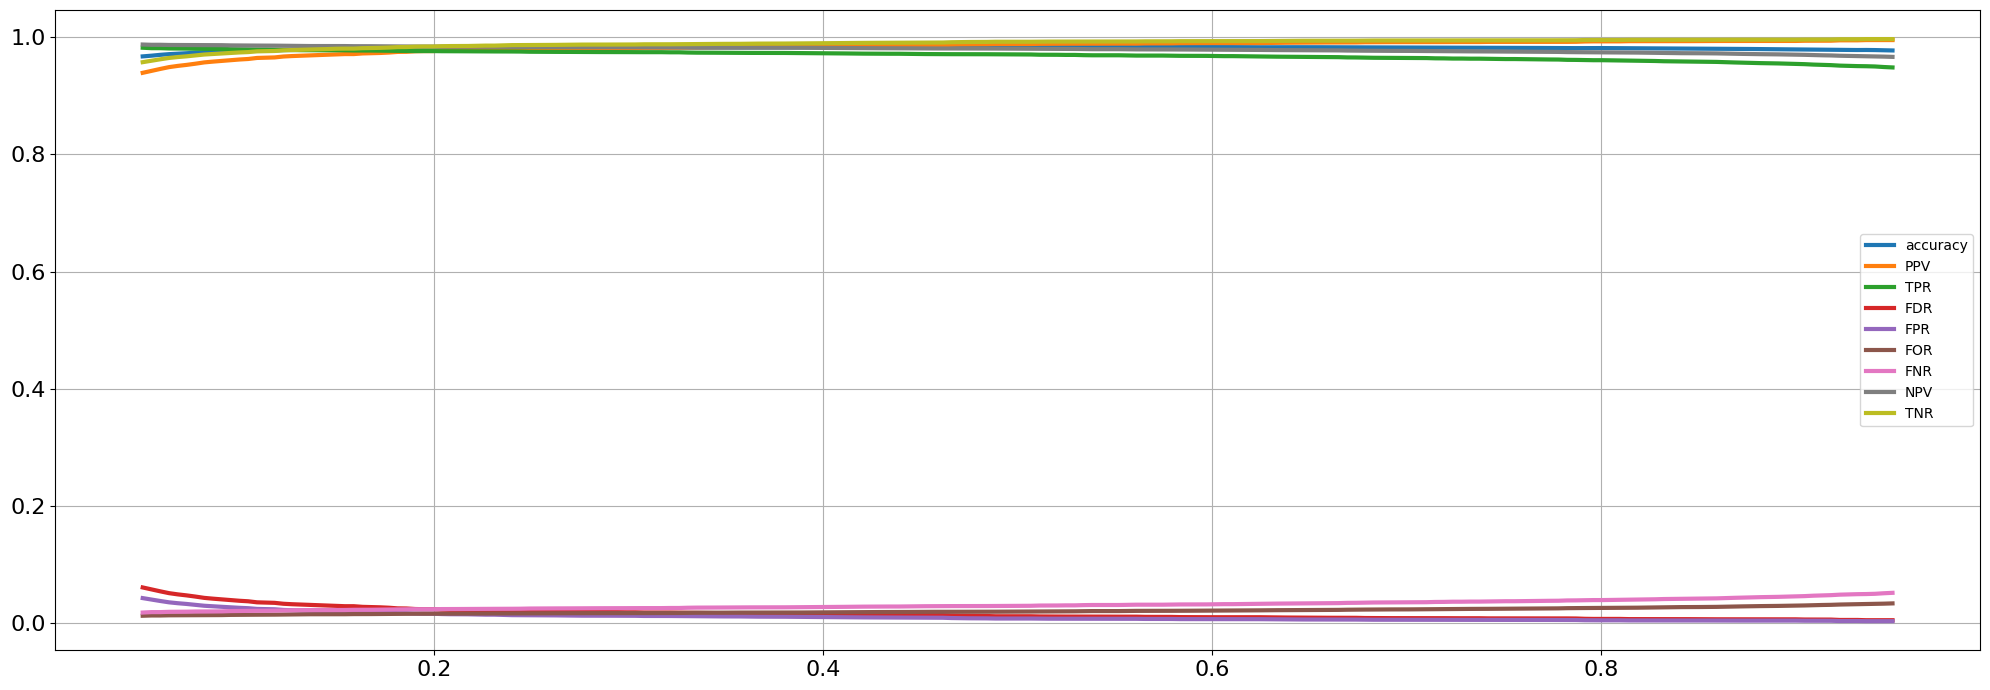

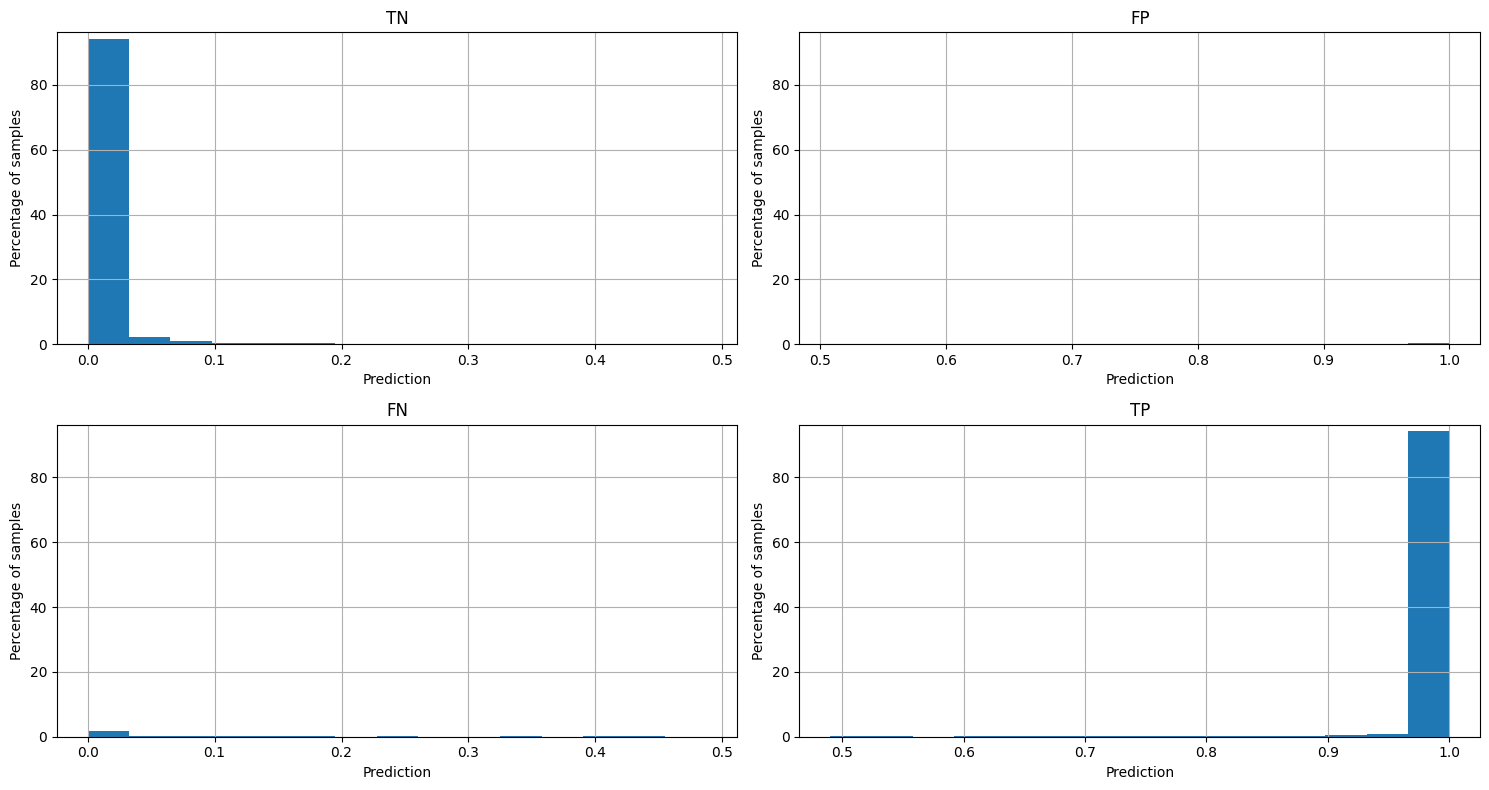

In [ ]:
# Custom evaluate
best_threshold = threshold_evaluation_plotter(X_test_encoded_padded, y_test)
mean_prediction = evaluate_nn_model(X_test_encoded_padded, y_test, threshold=best_threshold)

In [ ]:
# save RandomForestClassifier model to file
import pickle
import joblib

# save the model to a joblib file
pickle.dump(model, open("model.joblib", "wb"))

# save the model to a pickle file
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# # save the model to a joblib file
# joblib.dump(model, 'forest.joblib')

# **BiLSTM**

In [ ]:
model_biLSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, activation="tanh"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
# Compiling the model
model_biLSTM.compile(loss="binary_crossentropy", optimizer="adam", metrics=['acc'])
print(model_biLSTM.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          5376      
                                                                 
 bidirectional (Bidirectiona  (None, 256)              197632    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 236,033
Trainable params: 236,033
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
class_weight={0: (1/(oversampling_rate+1)), 1: (oversampling_rate/(oversampling_rate+1))}
print("Using the class weighting:", class_weight)
# Training the model
# Setting up callback to monitor the selected loss, and stops training if it doesnt improve for patience-number of epochs.
# After stopping training will restore the weights from the best iteration on this value encountered so far.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

Using the class weighting: {0: 0.4, 1: 0.6}


In [ ]:
history_biLSTM = model_biLSTM.fit(X_train_encoded_padded, y_train, epochs=100, validation_data=(X_test_encoded_padded, y_test), class_weight=class_weight,
                    sample_weight=sample_weights_train, callbacks=[early_stopping_callback])

Epoch 1/100
4253/4253 [==============================] - 442s 103ms/step - loss: 0.1207 - acc: 0.8624 - val_loss: 0.2690 - val_acc: 0.8828
Epoch 2/100
4253/4253 [==============================] - 425s 100ms/step - loss: 0.0854 - acc: 0.9033 - val_loss: 0.1915 - val_acc: 0.9208
Epoch 3/100
4253/4253 [==============================] - 433s 102ms/step - loss: 0.0651 - acc: 0.9299 - val_loss: 0.1536 - val_acc: 0.9390
Epoch 4/100
4253/4253 [==============================] - 441s 104ms/step - loss: 0.0482 - acc: 0.9509 - val_loss: 0.1279 - val_acc: 0.9510
Epoch 5/100
4253/4253 [==============================] - 443s 104ms/step - loss: 0.0345 - acc: 0.9662 - val_loss: 0.1001 - val_acc: 0.9657
Epoch 6/100
4253/4253 [==============================] - 443s 104ms/step - loss: 0.0248 - acc: 0.9777 - val_loss: 0.0840 - val_acc: 0.9722
Epoch 7/100
4253/4253 [==============================] - 444s 105ms/step - loss: 0.0177 - acc: 0.9845 - val_loss: 0.0784 - val_acc: 0.9753
Epoch 8/100
4253/4253 [====

In [ ]:
# Model built in evaluate
results_history_biLSTM = model_biLSTM.evaluate(X_test_encoded_padded, y_test)
print(results_history_biLSTM)

751/751 [==============================] - 22s 29ms/step - loss: 0.0720 - acc: 0.9787
[0.07200227677822113, 0.9786800146102905]


In [ ]:
# Testing some handcrafted examples to see how it does.
print("\nPhishing ULR examples:")
predict_url("frgcxtmjawefgrthdcusge.dab")
predict_url("bitso.transaccionsospechosa.com")
predict_url("newusutnet.com")
predict_url("webionos2fadll.weeblysite.com")
predict_url("analosmeme.pages.dev")
predict_url("poste.lnfo.31-42-177-87.cprapid.com")
predict_url("6463637838327.weebly.com")
predict_url("192.124.356.2.com")
predict_url("thisisphishing.com")

print("\nSafe URL examples:")
predict_url("linkedin.com")
predict_url("apple.com")
predict_url("github.com")
predict_url("tudelft.nl")
predict_url("facebook.com")
predict_url("stackoverflow.com")
predict_url("youtube.com")
predict_url("microsoft.com")
predict_url("uitm.com")
predict_url("jobstreet.com")
predict_url("x.com")

<ipython-input-26-e3b41c5c94e2>:138: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions_binary = predictions_boolean.astype(np.int)


Best performance at threshold: 0.4886934673366834
Calculated 24015 predictions with a mean value of 0.3967539966106415
Evaluating using threshold 0.4886934673366834
Cut-off threshold: 0.4887
Evaluation counts: {'TN': 14283, 'FP': 107, 'FN': 278, 'TP': 9347}
+------------------+----------------+--------------------+
| Accuracy 98.397% | Predicted safe | Predicted phishing |
+------------------+----------------+--------------------+
|   Not phishing   |   TN: 14283    |      FP: 107       |
|                  |  NPV: 98.091%  |    FDR: 1.132%     |
|                  |  TNR: 99.256%  |    FPR: 0.744%     |
|   Is phishing    |    FN: 278     |      TP: 9347      |
|                  |  FOR: 1.909%   |    PPV: 98.868%    |
|                  |  FNR: 2.888%   |    TPR: 97.112%    |
+------------------+----------------+--------------------+

Examples for TN Bin range: 0.00012415648 - 0.09761252 , Num. Samples: 14013
                               input  ground truth  prediction
0           

<ipython-input-26-e3b41c5c94e2>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions_binary = predictions_boolean.astype(np.int)



Examples for FN Bin range: 0.29260334 - 0.39008877 , Num. Samples: 16
                          input  ground truth  prediction
0                  rg-pixel.com             1    0.296254
1         start.budgethabit.com             1    0.351776
2   brookshoesfactoryoutlet.com             1    0.346960
3              st-thomasahs.com             1    0.302104
4     company.bridgeworkltd.com             1    0.319481
5                    taanug.org             1    0.349087
6          pentagonchemical.com             1    0.331858
7           rnusayfkl.jetos.com             1    0.320303
8                humanrights.mw             1    0.327654
9   assets.downtownmusicpub.com             1    0.332285
10              shirtronics.com             1    0.329906
11              srdapoplare.com             1    0.327602
12              moneycointv.com             1    0.327749
13          halvta.blogspot.com             1    0.376376
14                 faintlcn.com             1    0.384627



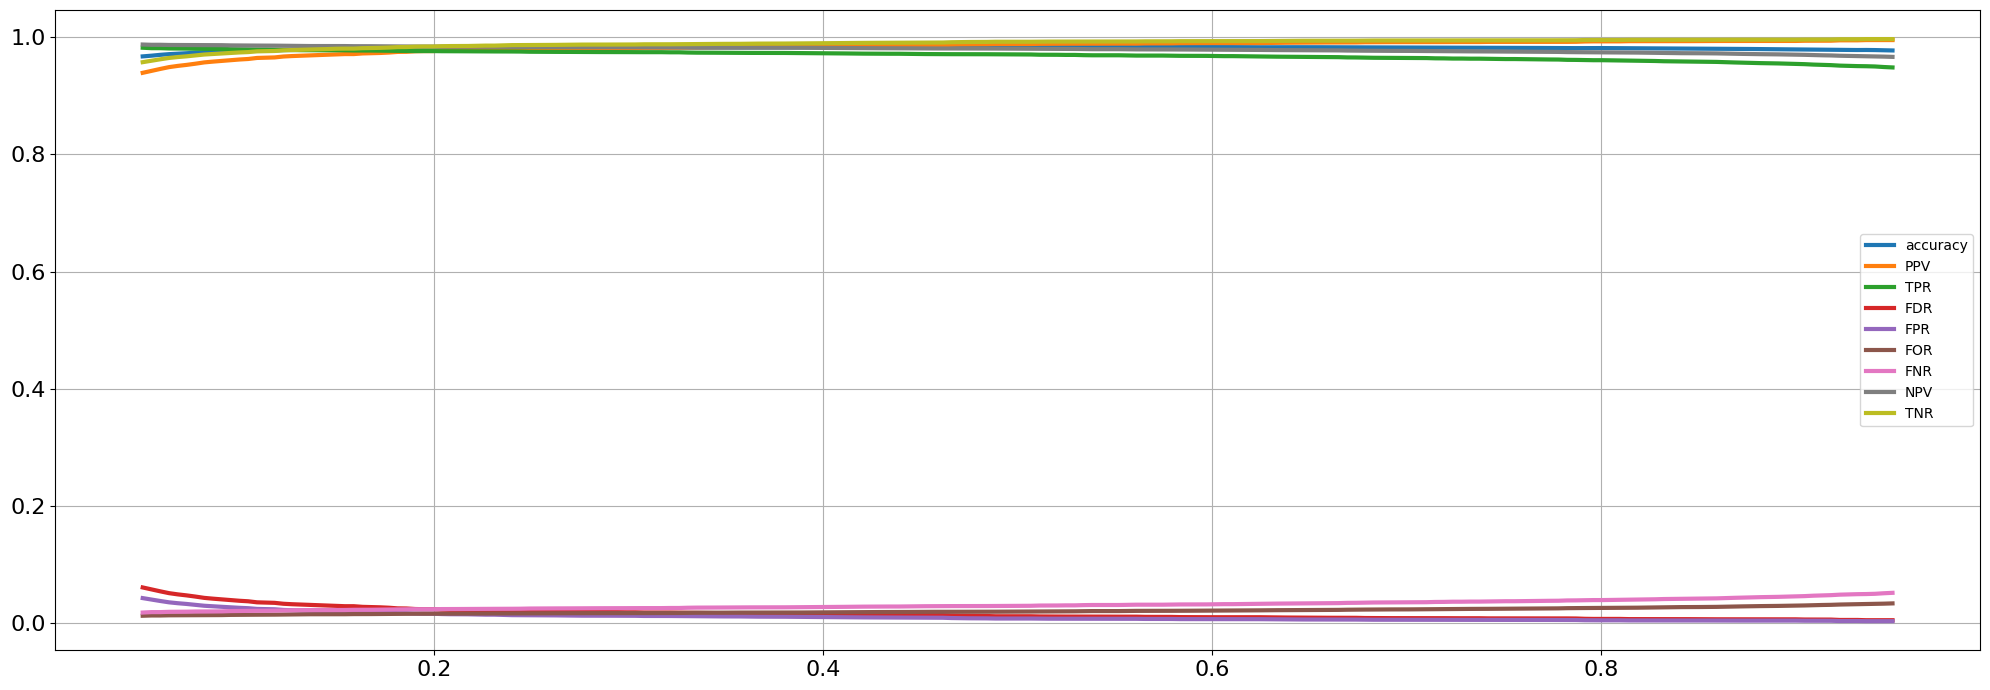

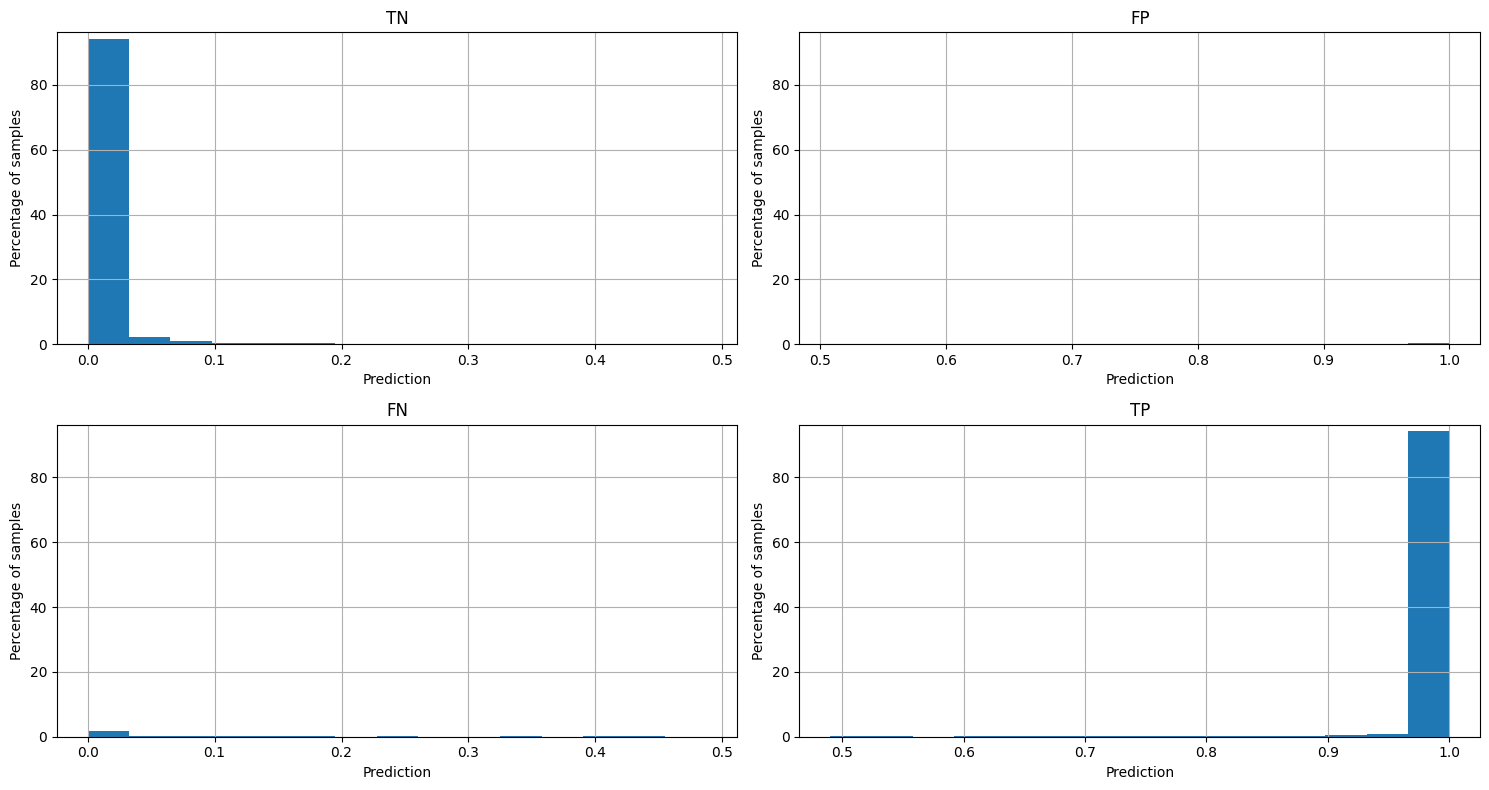

In [ ]:
# Custom evaluate
best_threshold_biLSTM = threshold_evaluation_plotter(X_test_encoded_padded, y_test)
mean_prediction_biLSTM = evaluate_nn_model(X_test_encoded_padded, y_test, threshold=best_threshold)

In [ ]:
# save the model to a joblib file
pickle.dump(model_biLSTM, open("model_biLSTM.joblib", "wb"))

# save the model to a pickle file
with open('model_biLSTM.pkl', 'wb') as model_file:
    pickle.dump(model_biLSTM, model_file)

# # save the model to a joblib file
# joblib.dump(model, 'forest.joblib')